<a href="https://colab.research.google.com/github/zhangxl2002/ORL/blob/main/T5_Ner_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Apr 21 00:39:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          Off  | 00000000:00:08.0 Off |                    0 |
|  0%   47C    P8    11W / 150W |      0MiB / 22731MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Named Entity Recognition with T5

This notebook shows how to finetune [T5 Model](https://https://huggingface.co/docs/transformers/model_doc/t5) for token classification or named entity recognition with pytorch lighning. In this demo, I used the T5-Small and cast the entities as a text using the text to text framework used in the t5 paper. During Eval the generated tokens are then split and classifies into their specific classes

In [2]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
# nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
# import pytorch_lightning as pl


from transformers import (
    AdamW,
    MT5ForConditionalGeneration,
    T5ForConditionalGeneration,
    T5Tokenizer,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)

from datasets import load_dataset

from datasets import load_metric

import matplotlib.pyplot as plt

import sys
import datetime

import shutil

/home/pai/envs/T5/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
def find_sub_list(sl, l):
    results = []
    sll = len(sl)
    for ind in (i for i, e in enumerate(l) if e == sl[0]):
        if l[ind:ind+sll] == sl:
            results.append((ind, ind+sll-1))
    return results

def generate_label(input: str, target: str):
    mapper = {
        "O": 0,
        "B-AGENT": 1,
        "I-AGENT": 2,
        "B-DSE": 3,
        "I-DSE": 4,
        "B-TARGET": 5,
        "I-TARGET": 6
    }
    inv_mapper = {v: k for k, v in mapper.items()}

    input = input.split(" ")
    target = target.split("; ")

    init_target_label = [mapper['O']]*len(input)

    for ent in target:
        ent = ent.split(": ")
        try:
            sent_end = ent[1].split(" ")
            index = find_sub_list(sent_end, input)
        except:
            continue
        # print(index)
        try:
            init_target_label[index[0][0]] = mapper[f"B-{ent[0].upper()}"]
            for i in range(index[0][0]+1, index[0][1]+1):
                init_target_label[i] = mapper[f"I-{ent[0].upper()}"]
        except:
            continue
    init_target_label = [inv_mapper[j] for j in init_target_label]
    return init_target_label

In [5]:
def save_array(name, table):
    np.save(name, table)

In [6]:
dataset = load_dataset("zhangxl2002/mpqa_ORL")

In [7]:
class MPQADataset(Dataset):
  def __init__(self, tokenizer, dataset, type_path, max_len=512):

    self.data = dataset[type_path]
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.tokenizer.max_length = max_len
    self.tokenizer.model_max_length = max_len
    self.inputs = []
    self.targets = []

    self._build()

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

  def _build(self):
    for idx in range(len(self.data)):
      input_, target = " ".join(self.data[idx]["words"]), "; ".join(self.data[idx]["spans"])
      input_ = input_ + " DSE:" + self.data[idx]["dse"]

      input_ = input_.lower() + ' </s>'
      target = target.lower() + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target],max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("../T5-base")

# print(tokenizer)

# input_dataset = MPQADataset(tokenizer=tokenizer, dataset=dataset, type_path='train')

In [9]:
# data = input_dataset[0]
# # print(data)
# print(tokenizer.decode(data["source_ids"][400]))
# print((tokenizer.decode(data["source_ids"][0:5])))
# print(tokenizer.encode("<unk>"))
# print(data["source_ids"][0:2])
# print(tokenizer.pad_token_id)
# print(tokenizer.decode(data["source_ids"], skip_special_tokens=False))
# print(tokenizer.decode(data["target_ids"], skip_special_tokens=False))

In [10]:
args_dict = dict(
    data_dir="zhangxl2002/mpqa_ORL", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=256,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=10,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=True, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

In [11]:
args = argparse.Namespace(**args_dict)

In [12]:
class T5FineTuner():
    def __init__(self, hparam):
        self.hparam = hparam
        # self.model = T5ForConditionalGeneration.from_pretrained(
        #     hparam.model_name_or_path)
        # self.model = T5ForConditionalGeneration.from_pretrained(
        #     "saved_models/model_epoch_7")
        self.model = T5ForConditionalGeneration.from_pretrained(
            "t5-base")
        self.tokenizer = AutoTokenizer.from_pretrained(
            hparam.model_name_or_path
        )
        self.configure_optimizers()
    def is_logger(self):
        return True

    def forward(
        self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self.model(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        # tensorboard_logs = {"train_loss": loss}
        # return {"loss": loss, "log": tensorboard_logs}
        return loss

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            loss = self._step(batch)
        return loss

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparam.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.hparam.learning_rate, eps=self.hparam.adam_epsilon)
        self.opt = optimizer
        return [optimizer]

    def optimizer_step(self,
                       epoch=None,
                       batch_idx=None,
                       optimizer=None,
                       optimizer_idx=None,
                       optimizer_closure=None,
                       on_tpu=None,
                       using_native_amp=None,
                       using_lbfgs=None
                       ):

        # optimizer.step(closure=optimizer_closure)
        # optimizer.zero_grad()
        self.opt.step()
        self.opt.zero_grad()
        # self.lr_scheduler.step()

    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(
            self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict

    def train_dataloader(self):
        train_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="train", args=self.hparam)
        dataloader = DataLoader(train_dataset, batch_size=self.hparam.train_batch_size,
                                drop_last=True, shuffle=True, num_workers=2)
        t_total = (
            (len(dataloader.dataset) //
             (self.hparam.train_batch_size * max(1, self.hparam.n_gpu)))
            // self.hparam.gradient_accumulation_steps
            * float(self.hparam.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparam.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        val_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="validation", args=self.hparam)
        return DataLoader(val_dataset, batch_size=self.hparam.eval_batch_size, num_workers=2)
    def test_dataloader(self):
        val_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="test", args=self.hparam)
        return DataLoader(val_dataset, batch_size=self.hparam.eval_batch_size, num_workers=2)

In [13]:
# model = T5FineTuner(args)

In [14]:
# from transformers import T5ForConditionalGeneration, T5Config
# config = T5Config.from_pretrained("t5-base")
# # 创建一个与原始模型相同架构的模型实例
# model = T5ForConditionalGeneration(config=config)

# # 加载之前保存的PyTorch模型的参数
# model.load_state_dict(torch.load("saved_models/model_epoch_3.pth"))

# # 将模型保存为Hugging Face的格式
# model.save_pretrained("./test_saved_models")

# # 模型现在已经转换为Hugging Face的形式并保存到指定路径下

In [15]:
# checkpointPath = "saveCheckpointPath/checkpoint.pth"

In [16]:
def get_dataset(tokenizer, type_path, args):
    tokenizer.max_length = args.max_seq_length
    tokenizer.model_max_length = args.max_seq_length
    # dataset = load_dataset(args.data_dir)
    dataset = load_dataset("zhangxl2002/mpqa_ORL")
    return MPQADataset(tokenizer=tokenizer, dataset=dataset, type_path=type_path)

In [17]:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.model.to(device)
# max_epochs = 10
# train_dataloader = model.train_dataloader()
# val_dataloader = model.val_dataloader()
# for epoch in range(max_epochs):
#     # 在验证集上计算损失
#     val_loss = 0.0
#     num_val_batches = 0
#     for i, val_batch in enumerate(val_dataloader):
#         val_batch = {key: value.to(device) for key, value in val_batch.items()}  # 将批次数据移动到GPU上
#         val_loss += model.validation_step(val_batch, i).item()
#         num_val_batches += 1
#     avg_val_loss = val_loss / num_val_batches
#     print("---------------------------------------")
#     print(f"Validation Loss: {avg_val_loss:.4f}")
#     print("---------------------------------------")
    
#     total_loss = 0.0
#     num_batches = 0
#     for i, batch in enumerate(train_dataloader):
#         batch = {key: value.to(device) for key, value in batch.items()}  # 将批次数据移动到GPU上
#         loss = model.training_step(batch, i)
#         loss.backward()
#         total_loss += loss.item()
#         num_batches += 1

#         # 打印每个批次的损失值
#         print(f"Epoch [{epoch + 1}/{max_epochs}], Batch [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

#         # 执行优化步骤
#         model.optimizer_step()
#     # 计算并打印平均损失值
#     avg_loss = total_loss / num_batches
#     print(f"Epoch [{epoch + 1}/{max_epochs}], Average Loss: {avg_loss:.4f}")

#     # 在验证集上计算损失
#     model.model.eval()
#     val_loss = 0.0
#     num_val_batches = 0
#     for i, val_batch in enumerate(val_dataloader):
#         val_batch = {key: value.to(device) for key, value in val_batch.items()}  # 将批次数据移动到GPU上
#         val_loss += model.validation_step(val_batch, i).item()
#         num_val_batches += 1
#     avg_val_loss = val_loss / num_val_batches
#     print("---------------------------------------")
#     print(f"Validation Loss: {avg_val_loss:.4f}")
#     print("---------------------------------------")
#     model.model.train()


#     save_dir = f"./saved_models/model_epoch_{epoch + 1}_trainloss_{avg_loss}_valloss_{avg_val_loss}"
#     model.model.save_pretrained(save_dir)
#     print(f"Model saved at {save_dir}")

    

    

In [18]:
# 使用AL对训练过程进行改写

In [19]:
class Datapool():
    def __init__(self, warmstart_percentage, train_dl):
        # self.train_dl = train_dl #
        # print("total_num:",len(train_dl.dataset))
        self.train_data = self.dataloader_to_list(train_dl)
        self.total_num = len(self.train_data)
        # print("total_num:",self.total_num)
        annotated_num = int(self.total_num * warmstart_percentage)
        annotated_indices = random.sample(range(self.total_num), annotated_num)
        annotated_indices.sort()
        self.annotated_data = [self.train_data[i] for i in annotated_indices]
        self.unannotated_data = [self.train_data[i] for i in range(self.total_num) if i not in annotated_indices]
        # print("len(annotated_data)",len(self.annotated_data))
        # print("len(unannotated_data)",len(self.unannotated_data))
        # print("self.annotated_data[0]",self.annotated_data[0])

        self.an_dataloader = DataLoader(self.annotated_data, batch_size=8, shuffle=False, drop_last=True, num_workers=2)
        self.un_dataloader = DataLoader(self.unannotated_data, batch_size=8, shuffle=False, drop_last=True, num_workers=2)

    def dataloader_to_list(self, dataloader):
        data_list = []
        cnt = 0
        for batch in dataloader:  
            for i in range(dataloader.batch_size):      
                data_list.append({
                    'source_ids':batch['source_ids'][i],
                    'target_ids':batch['target_ids'][i],
                    'source_mask':batch['source_mask'][i],
                    'target_mask':batch['target_mask'][i]
                })
        return data_list

    def getAnnotatedData(self):
        return self.annotated_data
    def getAnnotatedDataloader(self):
        return self.an_dataloader
    def getUnannotatedData(self):
        return self.unannotated_data
    def getUnannotatedDataloader(self):
        return self.un_dataloader
    def addAnnotatedData(self, selected_indices=[]):
        annotated_indices = selected_indices
        # annotated_indices.sort()
        self.annotated_data = self.annotated_data + [self.unannotated_data[i] for i in annotated_indices]
        self.unannotated_data = [self.unannotated_data[i] for i in range(len(self.unannotated_data)) if i not in annotated_indices]
        self.an_dataloader = DataLoader(self.annotated_data, batch_size=8, shuffle=True, drop_last=True, num_workers=2)
        self.un_dataloader = DataLoader(self.unannotated_data, batch_size=8, shuffle=False, drop_last=True, num_workers=2)
        self.showDetail()
    def showDetail(self):
        print("annotated_samples_num:", len(self.an_dataloader.dataset))
        print("unannotated_samples_num:", len(self.un_dataloader.dataset))


In [20]:
class T5FineTunerWithAL(T5FineTuner):
    def __init__(self, hparam, strategy_name="RANDOM", warmstart_percentage=0.05):
        super().__init__(hparam)
        self.warmstart_percentage = warmstart_percentage
        self.strategy = {
            # "RANDOM": RandomStrategy,
            # "LC": LeastConfidenceStrategy,
            # "NLC": NormalizedLeastConfidenceStrategy,
            # "LTP": LeastTokenProbabilityStrategy,
            # "MTP": MinimumTokenProbabilityStrategy,
            # "MTE": MaximumTokenEntropyStrategy,
            # "LONG": LongStrategy,
            # "TE": TokenEntropyStrategy,
        }
        self.strategy_name = strategy_name
        # self.strategy = self.strategy[strategy_name]
        self.datapool = Datapool(warmstart_percentage, super().train_dataloader())
    def resetModel(self):
        # 重置模型权重
        del self.model
        # self.model = T5ForConditionalGeneration.from_pretrained(
        #     "saved_models/model_epoch_7")
        self.model = T5ForConditionalGeneration.from_pretrained(
            "t5-base")
        # 重置优化器
        del self.opt
        self.configure_optimizers()
    def resetDatapool(self):
        del self.datapool
        self.datapool = Datapool(self.warmstart_percentage, super().train_dataloader())
    def update_datapool(self, strategy="RANDOM", add_percentage=0.0):
        un_data = self.datapool.getUnannotatedData()
        if strategy == "RANDOM":
            add_num = int(self.datapool.total_num * add_percentage)
            selected_idx = random.sample(range(len(self.datapool.unannotated_data)), add_num)
            # 展示得分高的 和得分低的数据
            show_num = 10
            print("--------------------show samples-----------------------")
            for sample in range(show_num):
                print("source:",self.tokenizer.decode(un_data[sample]["source_ids"], skip_special_tokens=True))
                print("target:",self.tokenizer.decode(un_data[sample]["target_ids"], skip_special_tokens=True))
            self.datapool.addAnnotatedData(selected_idx)
            return
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.model.to(device)
        cnt = 0

        un_dataloader = DataLoader(un_data, batch_size=8, shuffle=False)
        
        # for i in range(len(un_data)):
        #     outputs = model.model.generate(input_ids=un_data[i]["source_ids"],\
        #                 attention_mask=un_data[i]["source_mask"],return_dict_in_generate=True,output_scores=True,max_length=100)
        #     #output.scores是一个长度为输出的token数量的元组，元组中的每个元素为[batchsize,词表大小]的tensor
        #     transition_scores = model.model.compute_transition_scores(
        #         outputs.sequences, outputs.scores, normalize_logits=True
        #     )

        # TODO: 删除旧策略，新策略使用beam search找到得分最高的几个sequence

        # TODO:number_beams调大一点
        # 不同iter写死不同的epochnum
        # 应该采用所有epoch中在验证集上表现最较好的一个来进行主动学习
        # 保存断点
        # 是否数据集本身存在问题？
            
        #output.scores是一个长度为输出的token数量的元组，元组中的每个元素为[batchsize*num_return_sequences,词表大小]的tensor
        if add_percentage > 0:
            if strategy == "BEAM":
                beam_scores=[]
                number_beams = 2
                len_penalty = 0.0
                idx = 0
                for i, batch in enumerate(un_dataloader):
                    batch = {key: value.to(device) for key, value in batch.items()} 
                    outputs = model.model.generate(
                        input_ids=batch["source_ids"],
                        attention_mask=batch["source_mask"],
                        num_beams=number_beams,
                        num_return_sequences=number_beams,
                        return_dict_in_generate=True,
                        output_scores=True,
                        length_penalty=len_penalty,
                        max_length=500
                    )
                    transition_scores = model.model.compute_transition_scores(
                        outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=True
                    )
                    # compute_transition_scores计算出来的transition_scores是一个[batchsize*num_return_sequences,输出的token数量]的tensor，相当于对于每个输出的token一个评分

                    # input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
                    # 由于t5是encoder-decoder架构，所以这里input_length取1
                    generated_tokens = outputs.sequences[:, 1:] 
                    # generated_tokens是一个[batchsize,输出的token数量]的tensor，相当于每一个输出的token对应的id

                    output_length = np.sum(transition_scores.cpu().numpy() < 0, axis=1)
                    reconstructed_scores = transition_scores.cpu().sum(axis=1) / (output_length**len_penalty)
                    # 遍历batch中的每一条样本，计算对每一条样本的不确定程度
                    for i in range(0,int(generated_tokens.shape[0]/number_beams)):
                        beam_scores.append((idx, reconstructed_scores[i*number_beams]))
                        idx += 1
                sorted_beam_scores = sorted(beam_scores, key=lambda x: x[1])
                # print("sorted_beam_scores:", sorted_beam_scores)
                    
                selected_idx = [item[0] for item in sorted_beam_scores][:int(len(sorted_beam_scores) * add_percentage)]
                self.datapool.addAnnotatedData(selected_idx)
            elif strategy == "OTHER":
                # 假设已经知道实际的标签，根据产生的内容和实际的标签进行对比
                overall_f1_scores = []
                metric = load_metric("seqeval")
                len_penalty = 0.0
                idx = 0
                for i, batch in enumerate(un_dataloader):
                    batch = {key: value.to(device) for key, value in batch.items()} 
                    input_ids = batch['source_ids']
                    attention_mask = batch['source_mask']
                    outs = model.model.generate(input_ids=input_ids,
                                                attention_mask=attention_mask)
                    dec = [tokenizer.decode(ids, skip_special_tokens=True,
                                            clean_up_tokenization_spaces=False).strip() for ids in outs]
                    target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                                for ids in batch["target_ids"]]
                    texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                                for ids in batch["source_ids"]]
                    true_label = [generate_label(texts[i].strip(), target[i].strip()) if target[i].strip() != 'none' else [
                        "O"]*len(texts[i].strip().split()) for i in range(len(texts))]
                    pred_label = [generate_label(texts[i].strip(), dec[i].strip()) if dec[i].strip() != 'none' else [
                        "O"]*len(texts[i].strip().split()) for i in range(len(texts))]
                    for i in range(len(batch["source_ids"])):
                        overall_f1_scores.append((idx,metric.compute(predictions=[pred_label[i]], references=[true_label[i]])['overall_f1']))
                        idx += 1
                sorted_overall_f1_scores = sorted(overall_f1_scores, key=lambda x: x[1])
                print(sorted_overall_f1_scores[:10])
                selected_idx = [item[0] for item in sorted_overall_f1_scores][:int(len(sorted_overall_f1_scores) * add_percentage)]
                self.datapool.addAnnotatedData(selected_idx)            

        # print(tokenizer.decode(outputs.sequences[0], skip_special_tokens=True))
        

    # def val_dataloader(self):
    #     val_dataset = get_dataset(
    #         tokenizer=self.tokenizer, type_path="validation", args=self.hparam)
    #     return DataLoader(val_dataset, batch_size=self.hparam.eval_batch_size, num_workers=2)


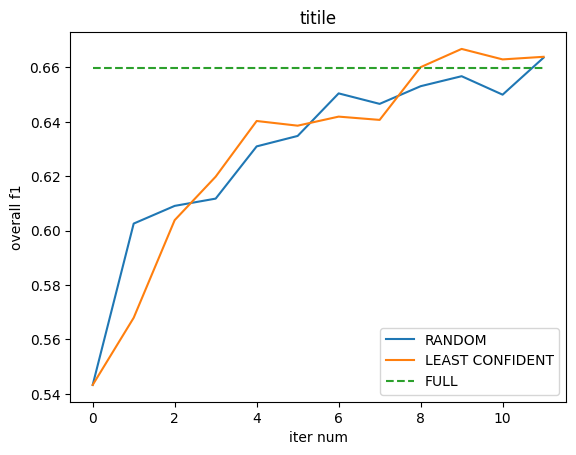

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 假设这是你的两个二维数组

# array1 = np.load("OTHER_result/OTHER_test_F1_overall_record.npy")[:-1]
# array2 = np.array([
#     [0.3919766 , 0.43706224, 0.48401826, 0.50829171, 0.46697039, 0.45134666, 0.46143705, 0.50239533, 0.44962166, 0.47957993, 0.        ],
#     [0.44843243, 0.48948765, 0.53057918, 0.53354633, 0.54318374, 0.52995008, 0.54117647, 0.5549958 , 0.54854175, 0.54972376, 0.        ],
#     [0.5159596 , 0.51100244, 0.53495066, 0.52618557, 0.53450493, 0.56368564, 0.5617039 , 0.570604  , 0.56399584, 0.56173842, 0.        ],
#     [0.52214547, 0.55932203, 0.54526621, 0.56973657, 0.53943692, 0.55845449, 0.55762987, 0.55578684, 0.57567623, 0.57160545, 0.        ],
#     [0.49553398, 0.52719495, 0.52411509, 0.5567418 , 0.57843341, 0.58064516, 0.57746777, 0.56535815, 0.56737297, 0.57748777, 0.        ],
#     [0.54474867, 0.56700824, 0.57449443, 0.567718  , 0.5724367 , 0.58377688, 0.59086079, 0.59287894, 0.58019923, 0.57206749, 0.        ],
#     [0.55152962, 0.53707089, 0.57739558, 0.58707692, 0.58072241, 0.60165223, 0.59777424, 0.60672731, 0.57714286, 0.57736905, 0.        ],
#     [0.5247691 , 0.58113362, 0.5768162 , 0.58033673, 0.59340215, 0.59010309, 0.5845115 , 0.59825509, 0.58798999, 0.57053942, 0.        ],
#     [0.5792089 , 0.55747966, 0.59683313, 0.58494799, 0.5950041 , 0.600244  , 0.58571122, 0.57721621, 0.58067158, 0.58794788, 0.        ],
#     [0.55697227, 0.556917  , 0.59746203, 0.60741916, 0.59250052, 0.57984752, 0.59491595, 0.5828039 , 0.59759635, 0.57862154, 0.        ],
#     [0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ]
# ])[:-1]
array2 = np.load("RANDOM_test_F1_overall_record.npy")[:-1]
array3 = np.load("BEAM_test_F1_overall_record.npy")[:-1]
# array4 = np.load("BEAM_result/BEAM_test_F1_overall_record.npy")[:-1]
# 求每行的最大值
# max_values_array1 = np.amax(array1, axis=1)
max_values_array2 = np.amax(array2, axis=1)
max_values_array3 = np.amax(array3, axis=1)
# max_values_array4 = np.amax(array4, axis=1)
array0 = np.array([0.65965985]*len(max_values_array2))
# 绘制折线图
# plt.plot(max_values_array1, label='')
plt.plot(max_values_array2, label='RANDOM')
plt.plot(max_values_array3, label='LEAST CONFIDENT')
# plt.plot(max_values_array4, label='LEAST CONFIDENT')
plt.plot(array0, linestyle="--",label='FULL')

# 添加图例、标题和标签
plt.legend()
plt.title('titile')
plt.xlabel('iter num')
plt.ylabel('overall f1')

# 显示图形
plt.show()



In [22]:
array0 = np.load("FULL_test_F1_overall_record.npy")
array0

array([0.60675422, 0.65965985, 0.64662226, 0.6496465 , 0.65445332,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [23]:
# array1 = np.load("OTHER_test_F1_overall_record.npy")[:-1]
# np.amax(array1, axis=1)

In [24]:
# model = T5FineTunerWithAL(args)

In [25]:
# number_beams=4 跑一次7分半
# model.update_datapool(strategy="OTHER",add_percentage=0.02)



In [26]:
# # 测试加入到annotateddata中的数据是否是预期中指标排在前面的数据
# metric = load_metric("seqeval")
# top5_samples = model.datapool.getAnnotatedData()[0:2]
# top5_dl = DataLoader(top5_samples, batch_size=8, shuffle=False, drop_last=False, num_workers=2)
# for i, batch in enumerate(top5_dl):
#     batch = {key: value.to("cuda") for key, value in batch.items()} 
#     input_ids = batch['source_ids']
#     attention_mask = batch['source_mask']
#     outs = model.model.generate(input_ids=input_ids,
#                                 attention_mask=attention_mask,
#                                 max_length=500,
#                                 num_beams=10)
#     print(outs)
#     dec = [tokenizer.decode(ids, skip_special_tokens=True,
#                             clean_up_tokenization_spaces=False).strip() for ids in outs]
#     target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
#                 for ids in batch["target_ids"]]
#     texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
#                 for ids in batch["source_ids"]]
#     true_label = [generate_label(texts[i].strip(), target[i].strip()) if target[i].strip() != 'none' else [
#         "O"]*len(texts[i].strip().split()) for i in range(len(texts))]
#     pred_label = [generate_label(texts[i].strip(), dec[i].strip()) if dec[i].strip() != 'none' else [
#         "O"]*len(texts[i].strip().split()) for i in range(len(texts))]
#     for i in range(len(batch["source_ids"])):
#         print(metric.compute(predictions=[pred_label[i]], references=[true_label[i]])['overall_f1'])
       

In [27]:
# 测试加入到annotateddata中的数据是否是预期中指标排在前面的数据
# top5_samples = model.datapool.getAnnotatedData()[0:3]
# top5_dl = DataLoader(top5_samples, batch_size=8, shuffle=False, drop_last=False, num_workers=2)

# for i, batch in enumerate(top5_dl):
#     batch = {key: value.to("cuda") for key, value in batch.items()} 
#     outputs = model.model.generate(
#         input_ids=batch["source_ids"],
#         attention_mask=batch["source_mask"],
#         num_beams=4,
#         num_return_sequences=4,
#         return_dict_in_generate=True,
#         output_scores=True,
#         length_penalty=1.0,
#         max_length=100
#     )
#     transition_scores = model.model.compute_transition_scores(
#     outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=True
#     )
#     output_length = np.sum(transition_scores.cpu().numpy() < 0, axis=1)
#     length_penalty = 1
#     reconstructed_scores = transition_scores.cpu().sum(axis=1) / (output_length**length_penalty)
#     torch.set_printoptions(precision=20)
#     print(outputs.sequences_scores)
#     print(reconstructed_scores)
#     print(np.exp(outputs.sequences_scores.cpu()))
#     print(np.exp(reconstructed_scores))
#     print(np.exp(reconstructed_scores).sum())
#     print(np.allclose(outputs.sequences_scores.cpu(), reconstructed_scores))



In [28]:
from datasets import load_metric

In [29]:
# np.load("MIN_result_v2/MIN_val_F1_overall_record.npy")

In [30]:
# 使用AL的做法
# model = T5FineTunerWithAL(args)

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_file_name = f"{current_time}.log"

write_log = True

# 将标准输出重定向到文件
if write_log:
    sys.stdout = open('log/'+log_file_name, 'w+')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_epochs = 15
epoch_nums = [6,7,8,9,10,11,12,13,14,15,15,15]


max_iters = 12 # 每个iterator选择新的数据加入已标注数据的集合并重新训练模型

# 初始化，默认初始标注数据占总数量的1%，使用RANDOM选择策略
model = T5FineTunerWithAL(args) 

# 验证集始终是一样的
test_dataloader = model.test_dataloader()
# test_dataloader = model.test_dataloader()

# strategies = ["RANDOM","BEAM","OTHER"]
strategies = ["RANDOM"]

print_log = True

# 记录loss和准确率
# loss：键为(strategy,iter,epoch 三元组 值为train_loss或者val_loss
train_loss_record = np.zeros((len(strategies) + 1, max_iters + 1, max_epochs + 1))
val_loss_record = np.zeros((len(strategies) + 1, max_iters + 1, max_epochs + 1))
val_F1_overall_record = np.zeros((len(strategies) + 1, max_iters + 1, max_epochs + 1))
val_F1_AGENT_record = np.zeros((len(strategies) + 1, max_iters + 1, max_epochs + 1))
val_F1_TARGET_record = np.zeros((len(strategies) + 1, max_iters + 1, max_epochs + 1))

test_loss_record = np.zeros((len(strategies) + 1, max_iters + 1, max_epochs + 1))
test_F1_overall_record = np.zeros((len(strategies) + 1, max_iters + 1, max_epochs + 1))
test_F1_AGENT_record = np.zeros((len(strategies) + 1, max_iters + 1, max_epochs + 1))
test_F1_TARGET_record = np.zeros((len(strategies) + 1, max_iters + 1, max_epochs + 1))




# new_folder = "model_newoneone"
# base_dir = f"./saved_models/strategy_test"
# full_dir = base_dir + "/" + new_folder
# model.model.save_pretrained(full_dir)
# print(f"Model saved at {full_dir}")
# files = os.listdir(base_dir)
# for file in files:
#     if file == new_folder:
#         continue
#     old_model_path = os.path.join(base_dir, file)
#     if os.path.isdir(old_model_path) and file.startswith("model"):
#         shutil.rmtree(old_model_path)
#         print("delete:",{file})

# print("-------------test finish--------------------")

for strategy_id in range(len(strategies)):
    current_strategy = strategies[strategy_id] 
    if print_log: print("strategy:", current_strategy)

    # 当前的策略，能够达到的最好的f1分数
    max_overall_f1 = 0.0 
    for iter in range(max_iters):
        if print_log: print("iter:", iter)
        # 对每轮新的数据都重新训练
        model.resetModel()
        if print_log: model.datapool.showDetail()
        model.model.to(device)

        # 训练集每轮更新，需要重新加载
        annotated_dataloader = model.datapool.getAnnotatedDataloader()

        for epoch in range(epoch_nums[iter]):
            # 训练
            total_loss = 0.0
            num_batches = 0

            for i, batch in enumerate(annotated_dataloader):
                batch = {key: value.to(device) for key, value in batch.items()}  # 将批次数据移动到GPU上
                loss = model.training_step(batch, i)
                loss.backward()
                total_loss += loss.item()
                num_batches += 1
                model.optimizer_step()
            avg_loss = total_loss / num_batches
            if print_log: print(f"Epoch [{epoch + 1}/{max_epochs}], Average Loss: {avg_loss:.4f}")


            # 每一个epoch训练完成后，在验证集上计算损失 计算token级别的precision,recall,F1
            val_loss = 0.0
            num_val_batches = 0

            test_loss = 0.0
            num_test_batches = 0

            true_labels = []
            pred_labels = []

            test_true_labels = []
            test_pred_labels = []
            model.model.eval()
            # for i, val_batch in enumerate(val_dataloader):
            #     # loss
            #     val_batch = {key: value.to(device) for key, value in val_batch.items()} 
            #     val_loss += model.validation_step(val_batch, i).item()
            #     num_val_batches += 1
            # for i, val_batch in enumerate(val_dataloader):
            #     # precision,recall,F1
            #     val_batch = {key: value.to(device) for key, value in val_batch.items()} 
            #     input_ids = val_batch['source_ids']
            #     attention_mask = val_batch['source_mask']
            #     val_outs = model.model.generate(input_ids=input_ids,
            #                                 attention_mask=attention_mask)
            #     val_dec = [tokenizer.decode(ids, skip_special_tokens=True,
            #                             clean_up_tokenization_spaces=False).strip() for ids in val_outs]
            #     val_target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
            #                 for ids in val_batch["target_ids"]]
            #     val_texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
            #                 for ids in val_batch["source_ids"]]
            #     true_label = [generate_label(val_texts[i].strip(), val_target[i].strip()) if val_target[i].strip() != 'none' else [
            #         "O"]*len(val_texts[i].strip().split()) for i in range(len(val_texts))]
            #     pred_label = [generate_label(val_texts[i].strip(), val_dec[i].strip()) if val_dec[i].strip() != 'none' else [
            #         "O"]*len(val_texts[i].strip().split()) for i in range(len(val_texts))]
            #     true_labels.extend(true_label)
            #     pred_labels.extend(pred_label)

            # for i, test_batch in enumerate(test_dataloader):
            #     # loss
            #     test_batch = {key: value.to(device) for key, value in test_batch.items()} 
            #     test_loss += model.validation_step(test_batch, i).item()
            #     num_test_batches += 1
            #     del test_batch

            for i, test_batch in enumerate(test_dataloader):
                # precision,recall,F1
                test_batch = {key: value.to(device) for key, value in test_batch.items()} 
                input_ids = test_batch['source_ids']
                attention_mask = test_batch['source_mask']
                test_outs = model.model.generate(input_ids=input_ids,
                                            attention_mask=attention_mask,
                                            max_length=500,
                                            num_beams=2)
                test_dec = [tokenizer.decode(ids, skip_special_tokens=True,
                                        clean_up_tokenization_spaces=False).strip() for ids in test_outs]
                test_target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                            for ids in test_batch["target_ids"]]
                test_texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                            for ids in test_batch["source_ids"]]
                true_label = [generate_label(test_texts[i].strip(), test_target[i].strip()) if test_target[i].strip() != 'none' else [
                    "O"]*len(test_texts[i].strip().split()) for i in range(len(test_texts))]
                pred_label = [generate_label(test_texts[i].strip(), test_dec[i].strip()) if test_dec[i].strip() != 'none' else [
                    "O"]*len(test_texts[i].strip().split()) for i in range(len(test_texts))]
                test_true_labels.extend(true_label)
                test_pred_labels.extend(pred_label)
                del test_batch
            model.model.train()

            metric = load_metric("seqeval")
            # metric_result = metric.compute(predictions=pred_labels, references=true_labels)
            test_metric_result = metric.compute(predictions=test_pred_labels, references=test_true_labels)
            # {'AGENT': {'precision': 0.7375415282392026, 'recall': 0.7449664429530202, 'f1': 0.7412353923205344, 'number': 1192}, \
            # 'TARGET': {'precision': 0.48408710217755446, 'recall': 0.4605577689243028, 'f1': 0.472029399755002, 'number': 1255}, \
            # 'overall_precision': 0.6113427856547122, 'overall_recall': 0.5991009399264405, 'overall_f1': 0.6051599587203303, 'overall_accuracy': 0.8741352105838087}


            # avg_val_loss = val_loss / num_val_batches
            # avg_test_loss = test_loss / num_test_batches
            if print_log: 
                print("-----------------------------------------------------------")
                print("strategy:", current_strategy)
                print("iter:", iter)
                print("epoch:", epoch)
                # print(f"Validation Loss: {avg_val_loss:.4f}")
                # print(f"F1_overall: {metric_result['overall_f1']:.4f}")
                # print(f"F1_AGENT: {metric_result['AGENT']['f1']:.4f}")
                # print(f"F1_TARGET: {metric_result['TARGET']['f1']:.4f}")

                # print(f"Test Loss: {avg_test_loss:.4f}")
                print(f"F1_overall: {test_metric_result['overall_f1']:.4f}")
                print(f"F1_AGENT: {test_metric_result['AGENT']['f1']:.4f}")
                print(f"F1_TARGET: {test_metric_result['TARGET']['f1']:.4f}")
                print("-----------------------------------------------------------")

            if test_metric_result['overall_f1'] > max_overall_f1:
                max_overall_f1 = test_metric_result['overall_f1']
                print("best_overall_f1 update:",max_overall_f1)
                if iter >= 0:
                    new_folder = f"model_F1_{max_overall_f1:.5f}_iter_{iter}_epoch_{epoch}"
                    base_dir = f"./saved_models/strategy_{current_strategy}"
                    full_dir = base_dir + "/" + new_folder
                    model.model.save_pretrained(full_dir)
                    print(f"Model saved at {full_dir}")
                    files = os.listdir(base_dir)
                    for file in files:
                        if file == new_folder:
                            continue
                        old_model_path = os.path.join(base_dir, file)
                        if os.path.isdir(old_model_path) and file.startswith("model"):
                            shutil.rmtree(old_model_path)
                            print(f"delete:{old_model_path}")
                    
            # train_loss_record[strategy_id][iter][epoch] = avg_loss

            # val_loss_record[strategy_id][iter][epoch] = avg_val_loss
            # val_F1_overall_record[strategy_id][iter][epoch] = metric_result['overall_f1']
            # val_F1_AGENT_record[strategy_id][iter][epoch] = metric_result['AGENT']['f1']
            # val_F1_TARGET_record[strategy_id][iter][epoch] = metric_result['TARGET']['f1']
            # save_array(current_strategy+"_train_loss_record", train_loss_record[strategy_id])
            # save_array(current_strategy+"_val_loss_record", val_loss_record[strategy_id])
            # save_array(current_strategy+"_val_F1_overall_record", val_F1_overall_record[strategy_id])
            # save_array(current_strategy+"_va1_F1_TARGET_record", val_F1_TARGET_record[strategy_id])
            # save_array(current_strategy+"_val_F1_AGENT_record", val_F1_AGENT_record[strategy_id])

            # test_loss_record[strategy_id][iter][epoch] = avg_test_loss
            test_F1_overall_record[strategy_id][iter][epoch] = test_metric_result['overall_f1']
            test_F1_AGENT_record[strategy_id][iter][epoch] = test_metric_result['AGENT']['f1']
            test_F1_TARGET_record[strategy_id][iter][epoch] = test_metric_result['TARGET']['f1']
            # save_array(current_strategy+"_test_loss_record", test_loss_record[strategy_id])
            save_array(current_strategy+"_test_F1_overall_record", test_F1_overall_record[strategy_id])
            save_array(current_strategy+"_test_F1_TARGET_record", test_F1_TARGET_record[strategy_id])
            save_array(current_strategy+"_test_F1_AGENT_record", test_F1_AGENT_record[strategy_id])

        # 所有epoch结束后，对未标注数据采用选择策略，选出新的标注数据，更新datapool
        model.update_datapool(strategy=current_strategy,add_percentage=0.05)
        if print_log: 
            print("update datapool!")
            model.datapool.showDetail()
    model.resetDatapool()
if write_log:
    sys.stdout.close()

# trainWithAL()


/home/pai/envs/T5/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current p

In [3]:
# 测试更新模型文件
import os, shutil
# 获取目录中的所有文件
directory = "./saved_models/deleteme"
new_folder = "aaa"
os.makedirs(os.path.join(directory, new_folder))
print("create:",{new_folder})
files = os.listdir(directory)
for file in files:
    if file == new_folder:
        continue
    full_path = os.path.join(directory, file)
    if os.path.isdir(full_path) and file.startswith("model"):
        shutil.rmtree(full_path)
        print("delete:",{file})




create: {'aaa'}
delete: {'model11'}


In [55]:
file_path

'./saved_models/model_epoch_3_trainloss_0.05953783357124902_valloss_0.23555645180333937'

In [30]:
# 不使用AL的训练流程
model = T5FineTuner(args)
max_epochs = 10
current_strategy = "FULL"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataloader = model.train_dataloader()
test_dataloader = model.test_dataloader()
print_log = True
write_log = False

model.model.to(device)
if write_log:
    sys.stdout = open('log/'+log_file_name, 'w+')

full_train_loss_record = np.zeros(max_epochs + 1)
full_test_loss_record = np.zeros(max_epochs + 1)
full_test_F1_overall_record= np.zeros(max_epochs + 1)
full_test_F1_AGENT_record = np.zeros(max_epochs + 1)
full_test_F1_TARGET_record = np.zeros(max_epochs + 1)
for epoch in range(max_epochs):
    # 训练
    total_loss = 0.0
    num_batches = 0
    model.model.train()
    for i, batch in enumerate(train_dataloader):
        # print(f"#######################################")
        # print(f"learning_rate:{model.lr_scheduler.get_last_lr()[-1]:.10f}")
        # print(f"learning_rate:{model.lr_scheduler.get_lr()}")
        # print(f"#######################################")
        batch = {key: value.to(device) for key, value in batch.items()}  # 将批次数据移动到GPU上
        loss = model.training_step(batch, i)
        loss.backward()
        total_loss += loss.item()
        num_batches += 1
        model.optimizer_step()
    avg_loss = total_loss / num_batches
    if print_log: 
        print(f"--------------Epoch [{epoch + 1}/{max_epochs}]---------------")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"learning_rate:{model.lr_scheduler.get_last_lr()[-1]:.10f}")
        print("-------------------------------------------------------------")


    # 每一个epoch训练完成后，在验证集上计算损失 计算token级别的precision,recall,F1
    test_loss = 0.0
    num_test_batches = 0

    true_labels = []
    pred_labels = []

    test_true_labels = []
    test_pred_labels = []
    model.model.eval()
    for i, test_batch in enumerate(test_dataloader):
        test_batch = {key: value.to(device) for key, value in test_batch.items()} 
        test_loss += model.validation_step(test_batch, i).item()
        num_test_batches += 1
        # del test_batch
    for i, test_batch in enumerate(test_dataloader):
        # precision,recall,F1
        test_batch = {key: value.to(device) for key, value in test_batch.items()} 
        input_ids = test_batch['source_ids']
        attention_mask = test_batch['source_mask']
        test_outs = model.model.generate(input_ids=input_ids,
                                    attention_mask=attention_mask,
                                    max_length=500,
                                    num_beams=2)
        test_dec = [tokenizer.decode(ids, skip_special_tokens=True,
                                clean_up_tokenization_spaces=False).strip() for ids in test_outs]
        test_target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                    for ids in test_batch["target_ids"]]
        test_texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                    for ids in test_batch["source_ids"]]
        true_label = [generate_label(test_texts[i].strip(), test_target[i].strip()) if test_target[i].strip() != 'none' else [
            "O"]*len(test_texts[i].strip().split()) for i in range(len(test_texts))]
        pred_label = [generate_label(test_texts[i].strip(), test_dec[i].strip()) if test_dec[i].strip() != 'none' else [
            "O"]*len(test_texts[i].strip().split()) for i in range(len(test_texts))]
        test_true_labels.extend(true_label)
        test_pred_labels.extend(pred_label)
        # del test_batch
    model.model.train()

    metric = load_metric("seqeval")
    # metric_result = metric.compute(predictions=pred_labels, references=true_labels)
    test_metric_result = metric.compute(predictions=test_pred_labels, references=test_true_labels)
    # {'AGENT': {'precision': 0.7375415282392026, 'recall': 0.7449664429530202, 'f1': 0.7412353923205344, 'number': 1192}, \
    # 'TARGET': {'precision': 0.48408710217755446, 'recall': 0.4605577689243028, 'f1': 0.472029399755002, 'number': 1255}, \
    # 'overall_precision': 0.6113427856547122, 'overall_recall': 0.5991009399264405, 'overall_f1': 0.6051599587203303, 'overall_accuracy': 0.8741352105838087}


    # avg_val_loss = val_loss / num_val_batches
    avg_test_loss = test_loss / num_test_batches
    if print_log: 
        print("-----------------------------------------------------------")
        print("strategy:", current_strategy)
        print("epoch:", epoch)
        # print(f"Validation Loss: {avg_val_loss:.4f}")
        # print(f"F1_overall: {metric_result['overall_f1']:.4f}")
        # print(f"F1_AGENT: {metric_result['AGENT']['f1']:.4f}")
        # print(f"F1_TARGET: {metric_result['TARGET']['f1']:.4f}")

        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"F1_overall: {test_metric_result['overall_f1']:.4f}")
        print(f"F1_AGENT: {test_metric_result['AGENT']['f1']:.4f}")
        print(f"F1_TARGET: {test_metric_result['TARGET']['f1']:.4f}")
        print("-----------------------------------------------------------")

    full_train_loss_record[epoch] = avg_loss

    full_test_loss_record[epoch] = avg_test_loss
    full_test_F1_overall_record[epoch] = test_metric_result['overall_f1']
    full_test_F1_AGENT_record[epoch] = test_metric_result['AGENT']['f1']
    full_test_F1_TARGET_record[epoch] = test_metric_result['TARGET']['f1']
    save_array(current_strategy+"_test_loss_record", full_test_loss_record)
    save_array(current_strategy+"_test_F1_overall_record", full_test_F1_overall_record)
    save_array(current_strategy+"_test_F1_TARGET_record", full_test_F1_TARGET_record)
    save_array(current_strategy+"_test_F1_AGENT_record", full_test_F1_AGENT_record)
if write_log:
    sys.stdout.close()

/home/pai/envs/T5/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--------------Epoch [1/10]---------------
Average Loss: 0.3657
learning_rate:0.0003000000
-------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

-----------------------------------------------------------
strategy: FULL
epoch: 0
Test Loss: 0.2504
F1_overall: 0.6068
F1_AGENT: 0.7180
F1_TARGET: 0.5009
-----------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--------------Epoch [2/10]---------------
Average Loss: 0.1882
learning_rate:0.0003000000
-------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

-----------------------------------------------------------
strategy: FULL
epoch: 1
Test Loss: 0.2154
F1_overall: 0.6597
F1_AGENT: 0.7637
F1_TARGET: 0.5639
-----------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--------------Epoch [3/10]---------------
Average Loss: 0.1375
learning_rate:0.0003000000
-------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

-----------------------------------------------------------
strategy: FULL
epoch: 2
Test Loss: 0.2470
F1_overall: 0.6466
F1_AGENT: 0.7537
F1_TARGET: 0.5444
-----------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--------------Epoch [4/10]---------------
Average Loss: 0.1095
learning_rate:0.0003000000
-------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

-----------------------------------------------------------
strategy: FULL
epoch: 3
Test Loss: 0.2677
F1_overall: 0.6496
F1_AGENT: 0.7402
F1_TARGET: 0.5576
-----------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--------------Epoch [5/10]---------------
Average Loss: 0.0826
learning_rate:0.0003000000
-------------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

-----------------------------------------------------------
strategy: FULL
epoch: 4
Test Loss: 0.2914
F1_overall: 0.6545
F1_AGENT: 0.7601
F1_TARGET: 0.5503
-----------------------------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KeyboardInterrupt: 

In [ ]:
# 不使用AL的训练流程
model = T5FineTuner(args)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataloader = model.train_dataloader()
test_dataloader = model.test_dataloader()
for epoch in range(max_epochs):
    # 在验证集上计算损失
    val_loss = 0.0
    num_val_batches = 0
    for i, val_batch in enumerate(val_dataloader):
        val_batch = {key: value.to(device) for key, value in val_batch.items()}  # 将批次数据移动到GPU上
        val_loss += model.validation_step(val_batch, i).item()
        num_val_batches += 1
    avg_val_loss = val_loss / num_val_batches
    print("---------------------------------------")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("---------------------------------------")
    
    total_loss = 0.0
    num_batches = 0
    for i, batch in enumerate(train_dataloader):
        batch = {key: value.to(device) for key, value in batch.items()}  # 将批次数据移动到GPU上
        loss = model.training_step(batch, i)
        loss.backward()
        total_loss += loss.item()
        num_batches += 1

        # 打印每个批次的损失值
        print(f"Epoch [{epoch + 1}/{max_epochs}], Batch [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

        # 执行优化步骤
        model.optimizer_step()
    # 计算并打印平均损失值
    avg_loss = total_loss / num_batches
    print(f"Epoch [{epoch + 1}/{max_epochs}], Average Loss: {avg_loss:.4f}")

    # 在验证集上计算损失
    model.model.eval()
    val_loss = 0.0
    num_val_batches = 0
    for i, val_batch in enumerate(val_dataloader):
        val_batch = {key: value.to(device) for key, value in val_batch.items()}  # 将批次数据移动到GPU上
        val_loss += model.validation_step(val_batch, i).item()
        num_val_batches += 1
    avg_val_loss = val_loss / num_val_batches
    print("---------------------------------------")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print("---------------------------------------")
    model.model.train()


    save_dir = f"./saved_models/model_epoch_{epoch + 1}_trainloss_{avg_loss}_valloss_{avg_val_loss}"
    model.model.save_pretrained(save_dir)
    print(f"Model saved at {save_dir}")

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_dataloader = model.val_dataloader()
model.model.to(device)
cnt = 0
for i, batch in enumerate(val_dataloader):
        batch = {key: value.to(device) for key, value in batch.items()} 
        outputs = model.model.generate(input_ids=batch["source_ids"],\
                attention_mask=batch["source_mask"],return_dict_in_generate=True,output_scores=True,max_length=500)
        
        cnt += 1
        if cnt > 1:
            break
        # if len(outputs.scores) == 19 :
        #     continue
        

        print("outputs.keys(): ",outputs.keys())
        print("len(outputs.scores)",len(outputs.scores))
        print("outputs.scores[0].shape:",outputs.scores[0].shape)
        print("len(outputs.scores):",len(outputs.scores))
        #output.scores是一个长度为输出的token数量的元组，元组中的每个元素为[batchsize,词表大小]的tensor
        print("outputs.scores[0].shape:",outputs.scores[0].shape) 
        print("ddddddddddddddddddddddddddddddddddddd",outputs.scores[0][0][0])

        transition_scores = model.model.compute_transition_scores(
            outputs.sequences, outputs.scores, normalize_logits=True
        )
        print("transition_scores.shape:", transition_scores.shape)
        # compute_transition_scores计算出来的transition_scores是一个[batchsize,输出的token数量]的tensor，相当于对于每个输出的token一个评分
        print("len(transition_scores[0]): ", len(transition_scores[0]))
        # print("transition_scores: ", transition_scores)

        # input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
        # 由于t5是encoder-decoder架构，所以这里input_length取1
        generated_tokens = outputs.sequences[:, 1:] 
        # generated_tokens是一个[batchsize,输出的token数量]的tensor，相当于每一个输出的token对应的id
        print("outputs.sequences: ", outputs.sequences)
        print("len(generated_tokens[0]):",len(generated_tokens[0]))
        print("generated_tokens: ",generated_tokens)

        # 遍历batch中的每一条样本，计算对每一条样本的不确定程度
        for i in range(generated_tokens.shape[0]):
            total_probs = 0.0 # 可能性的总和
            valid_num = 0 # 实际的token的数量
            min_probs = 1.0
            for tok, score in zip(generated_tokens[i], transition_scores[i]):
                if tok == 0:
                    break
                # | token | token string | logits | probability
                print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.cpu().numpy():.4f} |{np.exp(score.cpu().numpy()):.2%}")
                total_probs += np.exp(score.cpu().numpy())
                min_probs = min(min_probs, np.exp(score.cpu().numpy()))
                valid_num += 1
            if valid_num > 0:
                print("average prob:", total_probs/valid_num)
                print("min prob:", min_probs)
            
            print(tokenizer.decode(outputs.sequences[i], skip_special_tokens=True))
            print("----------------------------------------------")

        
        # print(tokenizer.decode(outputs.sequences[0], skip_special_tokens=True))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


outputs.keys():  odict_keys(['sequences', 'scores', 'past_key_values'])
len(outputs.scores) 35
outputs.scores[0].shape: torch.Size([8, 32128])
len(outputs.scores): 35
outputs.scores[0].shape: torch.Size([8, 32128])
ddddddddddddddddddddddddddddddddddddd tensor(-26.1285, device='cuda:0')
transition_scores.shape: torch.Size([8, 35])
len(transition_scores[0]):  35
outputs.sequences:  tensor([[    0,  2387,    10,  1045,  2371,     1,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [    0,  2387,    10,     3,     7,   232,    45,  8390,   844,     3,
             6,   902,     8,  4723,  1911,  7579,    23,     9, 21286,  1719,
             3,     6,    11, 12848,  5784,    45,     8,   690,     3,    31,
             7,     3, 24530,  1449,  1471,     1],
        [    0,  3102,    10,     3, 26

In [80]:
print("len(outputs.scores)",len(outputs.scores))
print(batch.keys())
print(batch["source_ids"].shape)
print(batch["source_mask"].shape)
print(batch["target_ids"].shape)

len(outputs.scores) 19
dict_keys(['source_ids', 'source_mask', 'target_ids', 'target_mask'])
torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8, 512])


In [16]:
logger = logging.getLogger(__name__)

class LoggingCallback():
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [17]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename=args.output_dir+"/checkpoint.pth", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    #early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    #amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

# train_params = dict(
#     accumulate_grad_batches=args.gradient_accumulation_steps,
#     ## gpus=args.n_gpu,
#     max_epochs=args.num_train_epochs,
#     #early_stop_callback=False,
#     precision= 16 if args.fp_16 else 32,
#     #amp_level=args.opt_level,
#     gradient_clip_val=args.max_grad_norm,
#     # callbacks=[LoggingCallback()],
# )

In [22]:
trainer = pl.Trainer(**train_params)

Using 16bit native Automatic Mixed Precision (AMP)
/home/pai/envs/T5/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fb6a2a8c9d0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fb6a2a8c9d0>)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model)

In [15]:
# model = model.load_from_checkpoint("/mnt/workspace/ORL/lightning_logs/version_4/checkpoints/epoch=9-step=279.ckpt")
model = model.model.from_pretrained("/mnt/workspace/ORL/lightning_logs/version_4/checkpoints/epoch=9-step=279.ckpt")

OSError: Incorrect path_or_model_id: '/mnt/workspace/ORL/lightning_logs/version_4/checkpoints/epoch=9-step=279.ckpt'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [16]:
import textwrap

dataloader = DataLoader(input_dataset, batch_size=32, num_workers=2, shuffle=True)
model.eval()
model = model.to("cpu")

In [17]:
outputs = []
targets = []
texts = []
cnt = 0
for batch in dataloader:

    outs = model.generate(input_ids=batch['source_ids'],
                                attention_mask=batch['source_mask'])
    dec = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip() for ids in outs]
    target = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip()
                for ids in batch["target_ids"]]
    text = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip()
                for ids in batch["source_ids"]]
    texts.extend(text)
    outputs.extend(dec)
    targets.extend(target)
    break


for i in range(10):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual Entities: %s" % target[i])
    print("Predicted Entities: %s" % outputs[i])
    print("=====================================================================\n")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/pai/envs/T5/lib/python3.9/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


text: i do n't , just so i can work in the school i 'll be happy . dse:happy

Actual Entities: target: work in the school; agent: i
Predicted Entities: agent: i

text: the uk foreign secretary , jack straw , said :  for months the government of zimbabwe has
conducted a systematic campaign of violence and intimidation , designed to achieve an outcome -
power at all costs . '' dse:said

Actual Entities: agent: the uk foreign secretary , jack straw; target: the government of zimbabwe
Predicted Entities: agent: the uk foreign secretary , jack straw; target: the government of zi

text: in the citizen , columnist rosa harris-adler wrote a devastatingly sarcastic piece ,
ridiculing mr. tobin 's assertion that he was leaving for family reasons . dse:ridiculing

Actual Entities: agent: rosa harris-adler
Predicted Entities: agent: rosa harris-adler; target: mr.

text: they 're actually going to paint arrows on the floors of the cells so they 'll know to face
north , '' he says . dse:says

Actual

In [ ]:
dir(model.model)

In [31]:
# search:how to get the probability huggingface
# https://discuss.huggingface.co/t/announcement-generation-get-probabilities-for-generated-output/30075

# 测试model.generate()方法用
model = T5FineTuner(args)
input_text = "I love the person who likes me. dse:love"
# input_texts = ["I love the person who likes me. dse:love","He loves his wife. dse:loves"]
max_length = 32
temperature = 1.0
num_samples = 1

# 推理
# inputs = tokenizer([input_text], return_tensors="pt")

inputs = tokenizer.batch_encode_plus(
    input_texts, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt"
)
# input_ids = tokenizer(input_text, return_tensors="pt").input_ids

source_text = "This is a source sentence."
source_ids = tokenizer(source_text, return_tensors="pt").input_ids


# outputs = model.generate(
#     **inputs,
#     max_new_tokens=5,
#     num_beams=4,
#     num_return_sequences=4,
#     return_dict_in_generate=True,
#     output_scores=True,
# )

# gen_outputs = model.model.generate(
#     inputs=source_ids,
#     num_beams=5,
#     min_length=0,
#     max_length=512,
#     length_penalty=0,
#     output_scores=True,
#     return_dict_in_generate=True,
# )

outputs = model.model.generate(
    inputs=source_ids,
    num_beams=5,
    min_length=0,
    max_length=512,
    length_penalty=0,
    output_scores=True,
    return_dict_in_generate=True)
# print(outputs)
print("outputs.keys(): ",outputs.keys())
print("outputs.scores[0].shape:",outputs.scores[0].shape)
print("len(outputs.scores):",len(outputs.scores))
#output.scores是一个长度为输出的token数量的元组，元组中的每个元素为batchsize*词表大小的tensor
print("outputs.scores[0].shape:",outputs.scores[0].shape) 

# compute_transition_scores计算出来的transition_scores是一个[batchsize*num_beams,输出的token数量]的tensor，相当于对于每个输出的token一个评分
transition_scores = model.model.compute_transition_scores(
    outputs.sequences, outputs.scores, normalize_logits=True
)
print("transition_scores.shape:", transition_scores.shape)
print("len(transition_scores[0]): ", len(transition_scores[0]))
# print("transition_scores: ", transition_scores)

print("outputs.sequences_scores:", outputs.sequences_scores.item())
print(transition_scores.sum())

# input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]
# 由于t5是encoder-decoder架构，所以这里input_length取1
generated_tokens = outputs.sequences[:, 1:] 
print("outputs.sequences: ", outputs.sequences)
print("len(generated_tokens[0]):",len(generated_tokens[0]))
print("generated_tokens: ",generated_tokens)
for i in range(generated_tokens.shape[0]):
    for tok, score in zip(generated_tokens[i], transition_scores[i]):
        # | token | token string | logits | probability
        print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.4f} |{np.exp(score.numpy()):.2%}")
    print("----------------------------------------------")

print(tokenizer.decode(outputs.sequences[0], skip_special_tokens=True))



outputs.keys():  odict_keys(['sequences', 'sequences_scores', 'scores', 'beam_indices', 'past_key_values'])
outputs.scores[0].shape: torch.Size([5, 32128])
len(outputs.scores): 11
outputs.scores[0].shape: torch.Size([5, 32128])
transition_scores.shape: torch.Size([5, 11])
len(transition_scores[0]):  11
outputs.sequences_scores: -1.9136189222335815
tensor(-558.4424)
outputs.sequences:  tensor([[    0, 32099,   100,    19,     3,     9,  1391,  7142,     5,     1]])
len(generated_tokens[0]): 9
generated_tokens:  tensor([[32099,   100,    19,     3,     9,  1391,  7142,     5,     1]])
| 32099 | <extra_id_0> | -24.7070 |0.00%
|   100 | This     | -6.1793 |0.21%
|    19 | is       | -11.8298 |0.00%
|     3 |          | -9.4976 |0.01%
|     9 | a        | -15.5207 |0.00%
|  1391 | source   | -12.2161 |0.00%
|  7142 | sentence | -13.4654 |0.00%
|     5 | .        | -9.9812 |0.00%
|     1 | </s>     | -0.0221 |97.81%
----------------------------------------------
This is a source sentence.


In [93]:
# generate和compute_transition_scores用法测试
inputs = tokenizer(["sdfadfasfasdfavzcvag"], return_tensors="pt")
outputs = model.model.generate(
    **inputs,
    max_new_tokens=5,
    num_beams=10,
    num_return_sequences=10,
    return_dict_in_generate=True,
    output_scores=True,
    length_penalty=0
)
transition_scores = model.model.compute_transition_scores(
    outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=False
)
# If you sum the generated tokens' scores and apply the length penalty, you'll get the sequence scores.
# Tip: set `normalize_logits=True` to recompute the scores from the normalized logits.
output_length = np.sum(transition_scores.numpy() < 0, axis=1)
length_penalty = 0
reconstructed_scores = transition_scores.sum(axis=1) / (output_length**length_penalty)
torch.set_printoptions(precision=20)
print(outputs.sequences_scores)
print(reconstructed_scores)
print(np.exp(outputs.sequences_scores))
print(np.exp(reconstructed_scores))
print(np.exp(reconstructed_scores).sum())
print(np.allclose(outputs.sequences_scores, reconstructed_scores))

tensor([-0.57641923427581787109, -1.59257841110229492188,
        -2.77720165252685546875, -3.55330038070678710938,
        -4.07467317581176757812, -4.47132682800292968750,
        -5.66037988662719726562, -5.95519733428955078125,
        -6.08485507965087890625, -6.08797788619995117188])
tensor([-0.57641923427581787109, -1.59257841110229492188,
        -2.77720165252685546875, -3.55330038070678710938,
        -4.07467317581176757812, -4.47132682800292968750,
        -5.66037988662719726562, -5.95519733428955078125,
        -6.08485555648803710938, -6.08797788619995117188], dtype=torch.float64)
tensor([0.56190681457519531250, 0.20340049266815185547, 0.06221235543489456177,
        0.02862999215722084045, 0.01699776947498321533, 0.01143213640898466110,
        0.00348119414411485195, 0.00259233219549059868, 0.00227709440514445305,
        0.00226999446749687195])
tensor([0.56190682520934231992, 0.20340048496015694646, 0.06221235580842737062,
        0.02862999367750398982, 0.0169977690

In [33]:
for batch in dataloader:

    outs = model.model.generate(input_ids=batch['source_ids'],
                                attention_mask=batch['source_mask'])
    # dec = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip() for ids in outs]
    # target = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip()
    #             for ids in batch["target_ids"]]
    # text = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip()
    #             for ids in batch["source_ids"]]
    # texts.extend(text)
    # outputs.extend(dec)
    # targets.extend(target)
    # cnt += 1
    # if cnt > 10:
    #     break
    print(outs)
    print(tokenizer.decode(outs[0], skip_special_tokens=True, clean_up_tokenization_spaces=False).strip())
    break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/pai/envs/T5/lib/python3.9/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[    0,  2387,    10,     8, 23997,  3368,   628,  2478,     1,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,  3102,    10,     3,    23,   117,  2387,    10,     3,  1258,
           189,    63,   410,    48, 24522,     1,     0,     0,     0,     0],
        [    0,  3102,    10,     8,   126, 25453,   648,     3,     6, 10381,
         11831,    15,     7,   648,    11,  6179,  6029,   442,   117,  2387],
        [    0,  2387,    10,     8,     3,   102,    29,   102,     1,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    0,  3102,    10,  7609,   261,    12,     8,  1075,    13,  1291,
          4028,   127,     7,   117,  2387,    10,  4297,  3101,    84,  4840],
        [    0,  3102,    10,   112,   117,  2387,    10, 26504,   323,    30,
             8,   962,     1,     0,     0,     0,     0,     0,     0,     0],
        [    0,  3102,    10,     3,     9,  1

In [41]:
print(outs[0])
print(tokenizer.decode(outs[0], skip_special_tokens=True, clean_up_tokenization_spaces=False).strip())

print(outs[1])
print(tokenizer.decode(outs[1], skip_special_tokens=True, clean_up_tokenization_spaces=False).strip())
for i in range(15):
    print(outs[1][i])
    print(tokenizer.decode(outs[1][i], skip_special_tokens=True, clean_up_tokenization_spaces=False).strip())

tensor([    0,  2387,    10,     8, 23997,  3368,   628,  2478,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
target: the christmas island space station
tensor([    0,  3102,    10,     3,    23,   117,  2387,    10,     3,  1258,
          189,    63,   410,    48, 24522,     1,     0,     0,     0,     0])
agent: i; target: kathy did this intentionally
tensor(0)

tensor(3102)
agent
tensor(10)
:
tensor(3)

tensor(23)
i
tensor(117)
;
tensor(2387)
target
tensor(10)
:
tensor(3)

tensor(1258)
ka
tensor(189)
th
tensor(63)
y
tensor(410)
did
tensor(48)
this
tensor(24522)
intentionally


In [27]:
from tqdm import tqdm

test_dataset = MPQADataset(tokenizer=tokenizer, dataset=dataset, type_path='test')
test_loader = DataLoader(test_dataset, batch_size=32,
                             num_workers=2, shuffle=True)
model.eval()
model = model.to("cuda")
outputs = []
targets = []
all_text = []
true_labels = []
pred_labels = []
for batch in tqdm(test_loader):
    input_ids = batch['source_ids'].to("cuda")
    attention_mask = batch['source_mask'].to("cuda")
    outs = model.generate(input_ids=input_ids,
                                attention_mask=attention_mask)
    dec = [tokenizer.decode(ids, skip_special_tokens=True,
                            clean_up_tokenization_spaces=False).strip() for ids in outs]
    target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                for ids in batch["target_ids"]]
    texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                for ids in batch["source_ids"]]
    true_label = [generate_label(texts[i].strip(), target[i].strip()) if target[i].strip() != 'none' else [
        "O"]*len(texts[i].strip().split()) for i in range(len(texts))]
    pred_label = [generate_label(texts[i].strip(), dec[i].strip()) if dec[i].strip() != 'none' else [
        "O"]*len(texts[i].strip().split()) for i in range(len(texts))]

    outputs.extend(dec)
    targets.extend(target)
    true_labels.extend(true_label)
    pred_labels.extend(pred_label)
    all_text.extend(texts)

  0%|          | 0/48 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/pai/envs/T5/lib/python3.9/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 48/48 [00

In [28]:
from datasets import load_metric

metric = load_metric("seqeval")

for i in range(10):
    print(f"Text:  {all_text[i]}")
    print(f"Predicted Token Class:  {pred_labels[i]}")
    print(f"True Token Class:  {true_labels[i]}")
    print("=====================================================================\n")

print(metric.compute(predictions=pred_labels, references=true_labels))
# {'AGENT': {'precision': 0.7375415282392026, 'recall': 0.7449664429530202, 'f1': 0.7412353923205344, 'number': 1192}, 'TARGET': {'precision': 0.48408710217755446, 'recall': 0.4605577689243028, 'f1': 0.472029399755002, 'number': 1255}, 'overall_precision': 0.6113427856547122, 'overall_recall': 0.5991009399264405, 'overall_f1': 0.6051599587203303, 'overall_accuracy': 0.8741352105838087}


/home/pai/envs/T5/lib/python3.9/site-packages/datasets/load.py:753: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Text:  we have been left with no alternative but to buy some weapons via our allies in the drc who have access to some of these european weapons that we have preference for . '' dse:have preference for
Predicted Token Class:  ['B-AGENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
True Token Class:  ['B-AGENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TARGET', 'I-TARGET', 'I-TARGET', 'I-TARGET', 'I-TARGET', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text:  all this has sounded the alarm for the us executive and suits the opposition 's objectives to bring about an intervention or a blockade , which would hurt the people it claims to defend . '' dse:claims
Predicted Token Class:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

# Model

Majority of the code here is adapted from [here](https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb) which uses the pytorch-lightning framework for training neural networks. T5 has shown that it can generate state of the art on many tasks as long as it can be cast as a text-to-text problem

In [4]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparam):
        super(T5FineTuner, self).__init__()
        self.hparam = hparam

        self.model = T5ForConditionalGeneration.from_pretrained(
            hparam.model_name_or_path)
        self.tokenizer = AutoTokenizer.from_pretrained(
            hparam.model_name_or_path
        )
        self.save_hyperparameters()

    def is_logger(self):
        return True

    def forward(
        self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparam.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.hparam.learning_rate, eps=self.hparam.adam_epsilon)
        self.opt = optimizer
        return [optimizer]

    def optimizer_step(self,
                       epoch=None,
                       batch_idx=None,
                       optimizer=None,
                       optimizer_idx=None,
                       optimizer_closure=None,
                       on_tpu=None,
                       using_native_amp=None,
                       using_lbfgs=None
                       ):

        optimizer.step(closure=optimizer_closure)
        optimizer.zero_grad()
        self.lr_scheduler.step()

    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(
            self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict

    def train_dataloader(self):
        train_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="train", args=self.hparam)
        dataloader = DataLoader(train_dataset, batch_size=self.hparam.train_batch_size,
                                drop_last=True, shuffle=True, num_workers=2)
        t_total = (
            (len(dataloader.dataset) //
             (self.hparam.train_batch_size * max(1, self.hparam.n_gpu)))
            // self.hparam.gradient_accumulation_steps
            * float(self.hparam.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparam.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        val_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="validation", args=self.hparam)
        return DataLoader(val_dataset, batch_size=self.hparam.eval_batch_size, num_workers=2)

In [5]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

In [6]:
args_dict = dict(
    data_dir="wikiann", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_seq_length=256,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=True, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

# Dataset

Here, I used the popular [WikiANN](https://https://huggingface.co/datasets/wikiann) dataset which is a multilingual named entity recognition dataset consisting of Wikipedia articles annotated with LOC (location), PER (person), and ORG (organisation) tags in the IOB2 format.

In [7]:
from datasets import load_dataset

dataset = load_dataset("wikiann", "en")

In [8]:
print(dataset)

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})


In [9]:
" ".join(dataset['train'][0]['tokens'])

'R.H. Saunders ( St. Lawrence River ) ( 968 MW )'

In [10]:
dataset['train'][0]

{'tokens': ['R.H.',
  'Saunders',
  '(',
  'St.',
  'Lawrence',
  'River',
  ')',
  '(',
  '968',
  'MW',
  ')'],
 'ner_tags': [3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0],
 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en'],
 'spans': ['ORG: R.H. Saunders', 'ORG: St. Lawrence River']}

In this section, we create a custom dataset class where we cast the NER task as a text to text problem. This is done by concatenating the spans in the data as one line of string separated by a semi-colon (;). e.g

*   **Input**: R.H. Saunders ( St. Lawrence River ) ( 968 MW )
*   **Target**: ORG: R.H. Saunders; ORG: St. Lawrence River




In [11]:
class WikiAnnDataset(Dataset):
  def __init__(self, tokenizer, dataset, type_path, max_len=512):

    self.data = dataset[type_path]
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.tokenizer.max_length = max_len
    self.tokenizer.model_max_length = max_len
    self.inputs = []
    self.targets = []

    self._build()

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

  def _build(self):
    for idx in range(len(self.data)):
      input_, target = " ".join(self.data[idx]["tokens"]), "; ".join(self.data[idx]["spans"])

      input_ = input_.lower() + ' </s>'
      target = target.lower() + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target],max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [12]:
tokenizer = AutoTokenizer.from_pretrained("../T5-base")

print(tokenizer)

input_dataset = WikiAnnDataset(tokenizer=tokenizer, dataset=dataset, type_path='train')

T5TokenizerFast(name_or_path='../T5-base', vocab_size=32100, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42

In [13]:
for i in range(len(input_dataset)):
    _ = input_dataset[i]

In [14]:
data = input_dataset[0]

print(tokenizer.decode(data["source_ids"], skip_special_tokens=False))
print(tokenizer.decode(data["target_ids"], skip_special_tokens=False))

r.h. saunders ( st. lawrence river ) ( 968 mw )</s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [15]:
!mkdir -p t5_ner

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
args = argparse.Namespace(**args_dict)
model = T5FineTuner(args)

In [17]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename=args.output_dir+"/checkpoint.pth", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    #early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    #amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

# train_params = dict(
#     accumulate_grad_batches=args.gradient_accumulation_steps,
#     ## gpus=args.n_gpu,
#     max_epochs=args.num_train_epochs,
#     #early_stop_callback=False,
#     precision= 16 if args.fp_16 else 32,
#     #amp_level=args.opt_level,
#     gradient_clip_val=args.max_grad_norm,
#     # callbacks=[LoggingCallback()],
# )

In [18]:
def get_dataset(tokenizer, type_path, args):
    tokenizer.max_length = args.max_seq_length
    tokenizer.model_max_length = args.max_seq_length
    dataset = load_dataset(args.data_dir, "en")
    return WikiAnnDataset(tokenizer=tokenizer, dataset=dataset, type_path=type_path)

In [19]:
trainer = pl.Trainer(**train_params)

Using 16bit native Automatic Mixed Precision (AMP)
/home/pai/envs/T5/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f6e53eb2f70>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f6e53eb2f70>)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [20]:
trainer.fit(model)

/home/pai/envs/T5/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:102: UserWarning: When using `Trainer(accumulate_grad_batches != 1)` and overriding `LightningModule.optimizer_{step,zero_grad}`, the hooks will not be called on every batch (rather, they are called on every optimization step).
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/pai/envs/T5/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
121.013   To

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/pai/envs/T5/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARAL

/home/pai/envs/T5/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s] 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/pai/envs/T5/lib/python3.9/site-packages/pytorch_lightning/loops/optimization/closure.py:35: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  rank_zero_deprec

Epoch 0:  67%|██████▋   | 2500/3750 [06:36<03:18,  6.30it/s, loss=0.138, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/1250 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Epoch 0:  67%|██████▋   | 2502/3750 [06:37<03:18,  6.30it/s, loss=0.138, v_num=0]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s, loss=0.138, v_num=0]           

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1:  67%|██████▋   | 2500/3750 [06:38<03:19,  6.28it/s, loss=0.125, v_num=0] 
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/1250 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Epoch 1:  67%|██████▋   | 2504/3750 [06:38<03:18,  6.28it/s, loss=0.125, v_num=0]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s, loss=0.125, v_num=0]           

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2:  67%|██████▋   | 2500/3750 [06:38<03:19,  6.28it/s, loss=0.0849, v_num=0]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/1250 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Epoch 2:  67%|██████▋   | 2502/3750 [06:38<03:18,  6.28it/s, loss=0.0849, v_num=0]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2: 100%|██████████| 3750/3750 [07:50<00:00,  7.98it/s, loss=0.0849, v_num=0]


## Load the Stored Model and Evaluate

In [23]:
model = model.load_from_checkpoint("/mnt/workspace/ORL/lightning_logs/version_0/checkpoints/epoch=2-step=470.ckpt")


In [24]:
import textwrap

dataloader = DataLoader(input_dataset, batch_size=32, num_workers=2, shuffle=True)
model.model.eval()
model = model.to("cpu")
outputs = []
targets = []
texts = []
for batch in dataloader:

    outs = model.model.generate(input_ids=batch['source_ids'],
                                attention_mask=batch['source_mask'])
    dec = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip() for ids in outs]
    target = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip()
                for ids in batch["target_ids"]]
    text = [tokenizer.decode(ids, skip_special_tokens=True, clean_up_tokenization_spaces=False).strip()
                for ids in batch["source_ids"]]
    texts.extend(text)
    outputs.extend(dec)
    targets.extend(target)
    break

for i in range(10):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual Entities: %s" % target[i])
    print("Predicted Entities: %s" % outputs[i])
    print("=====================================================================\n")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/pai/envs/T5/lib/python3.9/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


text: calhoun city , mississippi

Actual Entities: loc: calhoun city , mississippi
Predicted Entities: loc: calhoun city , mississippi

text: honorary fellow of the american institute of architects ( 1993 ) and of the royal institute of
british architects ( 1995 ) .

Actual Entities: org: american institute of architects; org: royal institute of british architects
Predicted Entities: org: american institute of architects; org: royal institute of british architects

text: museo di storia naturale di venezia , venice

Actual Entities: org: museo di storia naturale di venezia; loc: venice
Predicted Entities: loc: museo di storia naturale di venezia

text: edgar allan poe in popular culture

Actual Entities: org: edgar allan poe in popular culture
Predicted Entities: per: edgar allan poe in popular culture

text: '' shine my shoes ''

Actual Entities: org: shine my shoes
Predicted Entities: org: shine my shoes

text: värmlands län , seat no .

Actual Entities: org: värmlands län
Predicted 

In [25]:
def find_sub_list(sl, l):
    results = []
    sll = len(sl)
    for ind in (i for i, e in enumerate(l) if e == sl[0]):
        if l[ind:ind+sll] == sl:
            results.append((ind, ind+sll-1))
    return results

def generate_label(input: str, target: str):
    mapper = {'O': 0, 'B-DATE': 1, 'I-DATE': 2, 'B-PER': 3,
              'I-PER': 4, 'B-ORG': 5, 'I-ORG': 6, 'B-LOC': 7, 'I-LOC': 8}
    inv_mapper = {v: k for k, v in mapper.items()}

    input = input.split(" ")
    target = target.split("; ")

    init_target_label = [mapper['O']]*len(input)

    for ent in target:
        ent = ent.split(": ")
        try:
            sent_end = ent[1].split(" ")
            index = find_sub_list(sent_end, input)
        except:
            continue
        # print(index)
        try:
            init_target_label[index[0][0]] = mapper[f"B-{ent[0].upper()}"]
            for i in range(index[0][0]+1, index[0][1]+1):
                init_target_label[i] = mapper[f"I-{ent[0].upper()}"]
        except:
            continue
    init_target_label = [inv_mapper[j] for j in init_target_label]
    return init_target_label

In [26]:
from tqdm import tqdm

test_dataset = WikiAnnDataset(tokenizer=tokenizer, dataset=dataset, type_path='test')
test_loader = DataLoader(test_dataset, batch_size=32,
                             num_workers=2, shuffle=True)
model.model.eval()
model = model.to("cuda")
outputs = []
targets = []
all_text = []
true_labels = []
pred_labels = []
for batch in tqdm(test_loader):
    input_ids = batch['source_ids'].to("cuda")
    attention_mask = batch['source_mask'].to("cuda")
    outs = model.model.generate(input_ids=input_ids,
                                attention_mask=attention_mask)
    dec = [tokenizer.decode(ids, skip_special_tokens=True,
                            clean_up_tokenization_spaces=False).strip() for ids in outs]
    target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                for ids in batch["target_ids"]]
    texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                for ids in batch["source_ids"]]
    true_label = [generate_label(texts[i].strip(), target[i].strip()) if target[i].strip() != 'none' else [
        "O"]*len(texts[i].strip().split()) for i in range(len(texts))]
    pred_label = [generate_label(texts[i].strip(), dec[i].strip()) if dec[i].strip() != 'none' else [
        "O"]*len(texts[i].strip().split()) for i in range(len(texts))]

    outputs.extend(dec)
    targets.extend(target)
    true_labels.extend(true_label)
    pred_labels.extend(pred_label)
    all_text.extend(texts)

  0%|          | 0/313 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 313/313 [01:18<00:00,  3.97it/s]


In [27]:
all_text[1]

"orguss '' - additional voices"

In [29]:
from datasets import load_metric

metric = load_metric("seqeval")

for i in range(10):
    print(f"Text:  {all_text[i]}")
    print(f"Predicted Token Class:  {pred_labels[i]}")
    print(f"True Token Class:  {true_labels[i]}")
    print("=====================================================================\n")

print(metric.compute(predictions=pred_labels, references=true_labels))

/home/pai/envs/T5/lib/python3.9/site-packages/datasets/load.py:753: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text:  reginald beckwith as kenniston .
Predicted Token Class:  ['B-PER', 'I-PER', 'O', 'B-PER', 'O']
True Token Class:  ['B-PER', 'I-PER', 'O', 'O', 'O']

Text:  orguss '' - additional voices
Predicted Token Class:  ['B-ORG', 'O', 'O', 'O', 'O']
True Token Class:  ['B-ORG', 'O', 'O', 'O', 'O']

Text:  dihedral symmetry groups with even-orders have a number of subgroups .
Predicted Token Class:  ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O']
True Token Class:  ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Text:  council of southern africa football associations
Predicted Token Class:  ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG']
True Token Class:  ['B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG']

Text:  he died in 1924 and was buried in the hôtel des invalides .
Predicted Token Class:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O']
True Token Class:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O